In [1]:
from keras.datasets import imdb
from keras.utils import get_file
import pickle
import numpy as np
from keras.preprocessing import sequence
from keras.layers import Input, Dense, Embedding, Flatten, Dropout, Convolution1D, MaxPooling1D, concatenate, LSTM
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam


Using TensorFlow backend.


In [2]:
idx = imdb.get_word_index()
idx['hello']

4822

In [3]:
idx2word = {v: k for k, v in idx.items()}

In [4]:
sorted_idx = sorted(idx, key=idx.get)
sorted_idx[0:5]

['the', 'and', 'a', 'of', 'to']

In [5]:
#grab the imdb dataset
path = get_file('imdb_full.pkl',
                origin='https://s3.amazonaws.com/text-datasets/imdb_full.pkl',
                md5_hash='d091312047c43cf9e4e38fef92437263')
f = open(path, 'rb')
(x_train, labels_train), (x_test, labels_test) = pickle.load(f)

In [6]:
#test to see if download worked--should be 25000
len(x_train)

25000

In [7]:
#test to see if entries in imdb dataset are as they should be--should be a list of numbers
', '.join(map(str, x_train[0]))

'23022, 309, 6, 3, 1069, 209, 9, 2175, 30, 1, 169, 55, 14, 46, 82, 5869, 41, 393, 110, 138, 14, 5359, 58, 4477, 150, 8, 1, 5032, 5948, 482, 69, 5, 261, 12, 23022, 73935, 2003, 6, 73, 2436, 5, 632, 71, 6, 5359, 1, 25279, 5, 2004, 10471, 1, 5941, 1534, 34, 67, 64, 205, 140, 65, 1232, 63526, 21145, 1, 49265, 4, 1, 223, 901, 29, 3024, 69, 4, 1, 5863, 10, 694, 2, 65, 1534, 51, 10, 216, 1, 387, 8, 60, 3, 1472, 3724, 802, 5, 3521, 177, 1, 393, 10, 1238, 14030, 30, 309, 3, 353, 344, 2989, 143, 130, 5, 7804, 28, 4, 126, 5359, 1472, 2375, 5, 23022, 309, 10, 532, 12, 108, 1470, 4, 58, 556, 101, 12, 23022, 309, 6, 227, 4187, 48, 3, 2237, 12, 9, 215'

In [8]:
#test to see idx2word is working--should be 'bromwell'
idx2word[23022]

'bromwell'

In [9]:
#more check if idx2word is working--should show a whole review
' '.join([idx2word[o] for o in x_train[0]])

"bromwell high is a cartoon comedy it ran at the same time as some other programs about school life such as teachers my 35 years in the teaching profession lead me to believe that bromwell high's satire is much closer to reality than is teachers the scramble to survive financially the insightful students who can see right through their pathetic teachers' pomp the pettiness of the whole situation all remind me of the schools i knew and their students when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled at high a classic line inspector i'm here to sack one of your teachers student welcome to bromwell high i expect that many adults of my age think that bromwell high is far fetched what a pity that it isn't"

In [10]:
#make sure training labels are there 1 is for good review, 0 for negative
labels_train[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [11]:
vocab_size = 5000
#replaces the rare words
trn = [np.array([i if i<vocab_size-1 else vocab_size-1 for i in s]) for s in x_train]
test = [np.array([i if i<vocab_size-1 else vocab_size-1 for i in s]) for s in x_test]

In [12]:
seq_len = 500
trn = sequence.pad_sequences(trn, maxlen=seq_len, value=0)
test = sequence.pad_sequences(test, maxlen=seq_len, value=0)

In [13]:
#test to make sure training data is right shape, should be 25000,500
trn.shape

(25000, 500)

In [18]:
#first model with our own 50 dimensional word embeddings
input_tensor = Input(shape=(seq_len,), dtype='int32', name='main_input')

embedding_layer = Embedding(5000, 50, input_length=seq_len, name='main_embedding')(input_tensor)
embedding_layer = Dropout(0.2)(embedding_layer)

convs = [] 
for num in range (2, 5): 
    x = Convolution1D(64, num, padding='same', activation="relu")(embedding_layer)
    x = MaxPooling1D()(x) 
    x = Flatten()(x) 
    convs.append(x)

conv_out = Concatenate(name='concatenated_convs')(convs)
shortcut = Flatten(name='shortcut_main_embedding')(embedding_layer)
dense_in = Concatenate(name='concat_main_embedding_plus_convs')([conv_out, shortcut])

nex = Dropout(0.2)(dense_in)
nex = Dense(100, activation="relu", name='dense_consolidator')(nex)
nex = Dropout(0.2)(nex)
full_out = Dense (1, activation='sigmoid', name='final_output')(nex)

local_embedding_only_50_model = Model(input_tensor, full_out) 
local_embedding_only_50_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 500)           0                                            
____________________________________________________________________________________________________
main_embedding (Embedding)       (None, 500, 50)       250000                                       
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 500, 50)       0                                            
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 500, 64)       6464                                         
___________________________________________________________________________________________

In [19]:
local_embedding_only_50_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [20]:
local_embedding_only_50_model.fit(trn, labels_train, validation_data=(test, labels_test), epochs=2, batch_size=64, verbose=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 22s - loss: 0.4154 - acc: 0.7867 - val_loss: 0.2761 - val_acc: 0.8844

In [17]:
local_embedding_only_50_model.fit(trn, labels_train, validation_data=(test, labels_test), epochs=8, batch_size=64, verbose=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/8
25000/25000 [==============================] - 10s - loss: 0.0969 - acc: 0.9662 - val_loss: 0.3431 - val_acc: 0.8809
Epoch 2/8
25000/25000 [==============================] - 10s - loss: 0.0448 - acc: 0.9851 - val_loss: 0.4100 - val_acc: 0.8784
Epoch 3/8
25000/25000 [==============================] - 10s - loss: 0.0282 - acc: 0.9902 - val_loss: 0.4540 - val_acc: 0.8776
Epoch 4/8
25000/25000 [==============================] - 10s - loss: 0.0255 - acc: 0.9908 - val_loss: 0.4876 - val_acc: 0.8749
Epoch 5/8
25000/25000 [==============================] - 10s - loss: 0.0192 - acc: 0.9929 - val_loss: 0.5676 - val_acc: 0.8756
Epoch 6/8
25000/25000 [==============================] - 10s - loss: 0.0209 - acc: 0.9926 - val_loss: 0.6092 - val_acc: 0.8737
Epoch 7/8
25000/25000 [==============================] - 10s - loss: 0.0174 - acc: 0.9942 - val_loss: 0.5908 - val_acc: 0.8733
Epoch 8/8
25000/25000 [==============================] - 10s 

In [31]:
#second model with our own 100 dimensional word embeddings
input_tensor = Input(shape=(seq_len,), dtype='int32', name='main_input')

embedding_layer = Embedding(5000, 100, input_length=seq_len, name='main_embedding')(input_tensor)
embedding_layer = Dropout(0.2)(embedding_layer)

convs = [] 
for num in range (2, 5): 
    x = Convolution1D(64, num, padding='same', activation="relu")(embedding_layer)
    x = MaxPooling1D()(x) 
    x = Flatten()(x) 
    convs.append(x)

conv_out = Concatenate(name='concatenated_convs')(convs)
shortcut = Flatten(name='shortcut_main_embedding')(embedding_layer)
dense_in = Concatenate(name='concat_main_embedding_plus_convs')([conv_out, shortcut])

nex = Dropout(0.2)(dense_in)
nex = Dense(100, activation="relu", name='dense_consolidator')(nex)
nex = Dropout(0.2)(nex)
full_out = Dense (1, activation='sigmoid', name='final_output')(nex)

local_embedding_only_100_model = Model(input_tensor, full_out) 
local_embedding_only_100_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 500)           0                                            
____________________________________________________________________________________________________
main_embedding (Embedding)       (None, 500, 100)      500000                                       
____________________________________________________________________________________________________
dropout_8 (Dropout)              (None, 500, 100)      0                                            
____________________________________________________________________________________________________
conv1d_4 (Conv1D)                (None, 500, 64)       12864                                        
___________________________________________________________________________________________

In [32]:
local_embedding_only_100_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [33]:
local_embedding_only_100_history = local_embedding_only_100_model.fit(trn, labels_train, validation_data=(test, labels_test), epochs=2, batch_size=64, verbose=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 31s - loss: 0.4096 - acc: 0.7898 - val_loss: 0.2675 - val_acc: 0.8880

In [34]:
local_embedding_only_100_history_2 = local_embedding_only_100_model.fit(trn, labels_train, validation_data=(test, labels_test), epochs=8, batch_size=64, verbose=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/8
25000/25000 [==============================] - 29s - loss: 0.0761 - acc: 0.9742 - val_loss: 0.3629 - val_acc: 0.8811 - ETA: 27s - loss: 0.0877 - acc: 0.9785

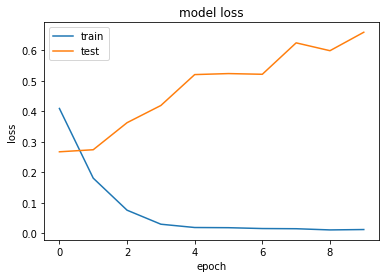

In [35]:
plt.plot(local_embedding_only_100_history.history['loss'] + local_embedding_only_100_history_2.history['loss'])
plt.plot(local_embedding_only_100_history.history['val_loss'] + local_embedding_only_100_history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
embeddings_index = {}
f = open('glove/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [23]:
word_index = idx
truncated_word_index = {key: value for key, value in word_index.items() if value < 5000}
print(len(truncated_word_index))
glove_embedding_dimension = 50
embedding_matrix = np.zeros((len(truncated_word_index) + 1, glove_embedding_dimension))
for word, i in truncated_word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

4999


In [35]:
#third model with glove 50 dimensional word embeddings only 
input_tensor = Input(shape=(seq_len,), dtype='int32', name='main_input')

glove_embedding_layer = Embedding(5000, 50, input_length=500, name='glove_embedding', weights=[embedding_matrix], trainable=False)(input_tensor)

convs = [] 
for num in range (2, 5): 
    x = Convolution1D(64, num, padding='same', activation="relu")(glove_embedding_layer)
    x = MaxPooling1D()(x) 
    x = Flatten()(x) 
    convs.append(x)

conv_out = Concatenate(name='concatenated_convs')(convs)
shortcut = Flatten(name='shortcut_main_embedding')(glove_embedding_layer)
dense_in = Concatenate(name='concat_main_embedding_plus_convs')([conv_out, shortcut])

nex = Dropout(0.2)(dense_in)
nex = Dense(100, activation="relu", name='dense_consolidator')(nex)
nex = Dropout(0.2)(nex)
full_out = Dense (1, activation='sigmoid', name='final_output')(nex)

glove_embedding_only_50_model = Model(input_tensor, full_out) 
glove_embedding_only_50_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 500)           0                                            
____________________________________________________________________________________________________
glove_embedding (Embedding)      (None, 500, 50)       250000      main_input[0][0]                 
____________________________________________________________________________________________________
conv1d_31 (Conv1D)               (None, 500, 64)       6464        glove_embedding[0][0]            
____________________________________________________________________________________________________
conv1d_32 (Conv1D)               (None, 500, 64)       9664        glove_embedding[0][0]            
___________________________________________________________________________________________

In [36]:
glove_embedding_only_50_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [37]:
glove_embedding_only_50_model.fit(trn, labels_train, validation_data=(test, labels_test), epochs=2, batch_size=64, verbose=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 9s - loss: 0.5714 - acc: 0.7000 - val_loss: 0.4612 - val_acc: 0.7844
Epoch 2/2
25000/25000 [==============================] - 9s - loss: 0.4038 - acc: 0.8184 - val_loss: 0.4204 - val_acc: 0.8064


In [38]:
glove_embedding_only_50_model.fit(trn, labels_train, validation_data=(test, labels_test), epochs=8, batch_size=64, verbose=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/8
25000/25000 [==============================] - 9s - loss: 0.3172 - acc: 0.8595 - val_loss: 0.4422 - val_acc: 0.8074
Epoch 2/8
25000/25000 [==============================] - 9s - loss: 0.2501 - acc: 0.8934 - val_loss: 0.5008 - val_acc: 0.8018
Epoch 3/8
25000/25000 [==============================] - 9s - loss: 0.1976 - acc: 0.9175 - val_loss: 0.4814 - val_acc: 0.8112
Epoch 4/8
25000/25000 [==============================] - 9s - loss: 0.1517 - acc: 0.9368 - val_loss: 0.6004 - val_acc: 0.8141
Epoch 5/8
25000/25000 [==============================] - 9s - loss: 0.1266 - acc: 0.9470 - val_loss: 0.5844 - val_acc: 0.8136
Epoch 6/8
25000/25000 [==============================] - 9s - loss: 0.1021 - acc: 0.9566 - val_loss: 0.6650 - val_acc: 0.8134
Epoch 7/8
25000/25000 [==============================] - 9s - loss: 0.0944 - acc: 0.9598 - val_loss: 0.7043 - val_acc: 0.8095
Epoch 8/8
25000/25000 [==============================] - 9s - loss: 

In [39]:
#fourth model combining our local embedding along with the glove embedding
input_tensor = Input(shape=(500,), dtype='int32', name='main_input')

embedding_layer = Embedding(5000, 50, input_length=500, name='main_embedding')(input_tensor)
embedding_layer = Dropout(0.2)(embedding_layer)

glove_embedding_layer = Embedding(5000, 50, input_length=500, name='glove_embedding', weights=[embedding_matrix], trainable=False)(input_tensor)

convs = [] 
for num in range (2, 5): 
    x = Convolution1D(64, num, padding='same', activation="relu")(embedding_layer)
    x = MaxPooling1D()(x) 
    x = Flatten()(x) 
    convs.append(x)

for num in range (2, 5): 
    x = Convolution1D(64, num, padding='same', activation="relu")(glove_embedding_layer)
    x = MaxPooling1D()(x) 
    x = Flatten()(x) 
    convs.append(x)

conv_out = Concatenate(name='concatenated_convs')(convs)
shortcut = Flatten(name='shortcut_main_embedding')(embedding_layer)
dense_in = Concatenate(name='concat_main_embedding_plus_convs')([conv_out, shortcut])

nex = Dropout(0.2)(dense_in)
nex = Dense(100, activation="relu", name='dense_consolidator')(nex)
nex = Dropout(0.2)(nex)
full_out = Dense (1, activation='sigmoid', name='final_output')(nex)

combined_50_50_model = Model(input_tensor, full_out) 
combined_50_50_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 500)           0                                            
____________________________________________________________________________________________________
main_embedding (Embedding)       (None, 500, 50)       250000      main_input[0][0]                 
____________________________________________________________________________________________________
dropout_27 (Dropout)             (None, 500, 50)       0           main_embedding[0][0]             
____________________________________________________________________________________________________
glove_embedding (Embedding)      (None, 500, 50)       250000      main_input[0][0]                 
___________________________________________________________________________________________

In [40]:
combined_50_50_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [41]:
combined_50_50_model.fit(trn, labels_train, validation_data=(test, labels_test), epochs=2, batch_size=64, verbose=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 17s - loss: 0.4411 - acc: 0.7729 - val_loss: 0.2913 - val_acc: 0.8785
Epoch 2/2
25000/25000 [==============================] - 17s - loss: 0.2114 - acc: 0.9179 - val_loss: 0.2703 - val_acc: 0.8878


In [42]:
combined_50_50_model.fit(trn, labels_train, validation_data=(test, labels_test), epochs=8, batch_size=64, verbose=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/8
25000/25000 [==============================] - 17s - loss: 0.1249 - acc: 0.9549 - val_loss: 0.3160 - val_acc: 0.8831
Epoch 2/8
25000/25000 [==============================] - 17s - loss: 0.0591 - acc: 0.9802 - val_loss: 0.4170 - val_acc: 0.8746
Epoch 3/8
25000/25000 [==============================] - 17s - loss: 0.0370 - acc: 0.9884 - val_loss: 0.4359 - val_acc: 0.8747
Epoch 4/8
25000/25000 [==============================] - 17s - loss: 0.0250 - acc: 0.9915 - val_loss: 0.5394 - val_acc: 0.8742
Epoch 5/8
25000/25000 [==============================] - 17s - loss: 0.0227 - acc: 0.9925 - val_loss: 0.5616 - val_acc: 0.8778
Epoch 6/8
25000/25000 [==============================] - 17s - loss: 0.0184 - acc: 0.9939 - val_loss: 0.6114 - val_acc: 0.8755
Epoch 7/8
25000/25000 [==============================] - 17s - loss: 0.0173 - acc: 0.9944 - val_loss: 0.6879 - val_acc: 0.8789
Epoch 8/8
25000/25000 [==============================] - 17s 

In [21]:
# Going to try parallel LSTMs and see how it does. First experiment: single LSTM
input_tensor = Input(shape=(seq_len,), dtype='int32', name='main_input')

embedding_layer = Embedding(5000, 50, input_length=seq_len, name='main_embedding')(input_tensor)
embedding_layer = Dropout(0.2)(embedding_layer)

x = LSTM(128, dropout=0.1, recurrent_dropout=0.1)(embedding_layer)
full_out = Dense(1, activation='sigmoid')(x)

single_lstm_model = Model(input_tensor, full_out)

In [22]:
single_lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 500)               0         
_________________________________________________________________
main_embedding (Embedding)   (None, 500, 50)           250000    
_________________________________________________________________
dropout_5 (Dropout)          (None, 500, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 341,777.0
Trainable params: 341,777.0
Non-trainable params: 0.0
_________________________________________________________________


In [23]:
single_lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [24]:
single_lstm_history = single_lstm_model.fit(trn, labels_train, validation_data=(test, labels_test), epochs=2, batch_size=64, verbose=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 341s - loss: 0.4841 - acc: 0.7611 - val_loss: 0.3555 - val_acc: 0.8528

In [25]:
single_lstm_history_2 = single_lstm_model.fit(trn, labels_train, validation_data=(test, labels_test), epochs=10, batch_size=64, verbose=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 336s - loss: 0.3619 - acc: 0.8452 - val_loss: 0.4168 - val_acc: 0.8085

In [26]:
# Now, some parallel LSTMs
input_tensor = Input(shape=(seq_len,), dtype='int32', name='main_input')

embedding_layer = Embedding(5000, 50, input_length=seq_len, name='main_embedding')(input_tensor)
embedding_layer = Dropout(0.2)(embedding_layer)

lstms = [] 

for i in range(0,8):
    x = LSTM(128, dropout=0.1, recurrent_dropout=0.1, name='lstm_'+ str(i))(embedding_layer)
    lstms.append(x)
    
lstms_out = Concatenate(name='concatenated_lstms')(lstms)
nex = Dense(100, activation="relu", name='dense_consolidator')(lstms_out)

nex = Dropout(0.2)(nex)
full_out = Dense (1, activation='sigmoid', name='final_output')(nex)

ten_lstms_model = Model(input_tensor, full_out) 
ten_lstms_model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 500)           0                                            
____________________________________________________________________________________________________
main_embedding (Embedding)       (None, 500, 50)       250000                                       
____________________________________________________________________________________________________
dropout_6 (Dropout)              (None, 500, 50)       0                                            
____________________________________________________________________________________________________
lstm_0 (LSTM)                    (None, 128)           91648                                        
___________________________________________________________________________________________

In [27]:
ten_lstms_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [28]:
ten_lstms_history = ten_lstms_model.fit(trn, labels_train, validation_data=(test, labels_test), epochs=2, batch_size=32, verbose=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 5130s - loss: 0.4881 - acc: 0.7602 - val_loss: 0.4562 - val_acc: 0.7762

In [29]:
ten_lstms_history_2 = ten_lstms_model.fit(trn, labels_train, validation_data=(test, labels_test), epochs=8, batch_size=32, verbose=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/8
25000/25000 [==============================] - 5155s - loss: 0.3835 - acc: 0.8327 - val_loss: 0.4594 - val_acc: 0.7963

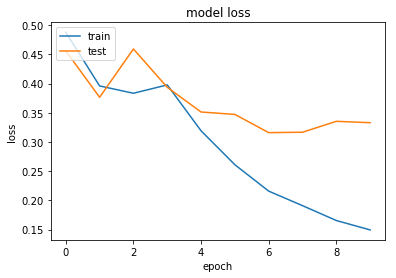

In [30]:
import matplotlib.pyplot as plt
plt.plot(ten_lstms_history.history['loss'] + ten_lstms_history_2.history['loss'])
plt.plot(ten_lstms_history.history['val_loss'] + ten_lstms_history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()